# Libraries

In [1]:
import pandas as pd

import regex as re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
import pyLDAvis.gensim_models as gensimvis


import gensim
# from gensim.models import wrappers
# from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD


import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from pprint import pprint

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


# Importing -- Fixing columns

In [2]:
full = pd.read_csv('Data/Data-Cleaned/238k-Uncleaned')

In [3]:
# Renaming tweets column, dropping unnamed column, making tweets strings

full['tweets'] = full['0']
full = full.drop(columns = '0')

# Preprocessing

In [6]:
def Series_Preprocessor(tweet):
    stopWords = stopwords.words('english')
    stopWords.extend(['tesla', 'c,', 'x', 't', 'p', 'amp'])
    ps = PorterStemmer()
    wnl = WordNetLemmatizer()

        # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None 
    
#   Lowercase all 
    tweet = tweet.lower()
    
#   Removing @ handles, links-- strip whitespace breaks and tabs
    tweet = re.sub(r"@\w+|http\S+", "", tweet).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
#   Tokenize,make list of words, removing punctuation and stopwords
    tweet = [x for x in word_tokenize(tweet) if ((x.isalpha()) & (x not in stopWords)) ]
    
#   Map part of speech tags to words and use words/tags to lemmatize accuratley
    tweet = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet))) 
    tweet = " ".join([wnl.lemmatize(x[0], x[1]) for x in tweet if x[1] is not None])

    return tweet 

In [7]:
df = full['tweets'].apply(Series_Preprocessor)

In [9]:
df['tokens'] = [i.split() for i in df]

In [10]:
# Dictionary is a gensim tool
id2word = Dictionary(df['tokens'])
print(len(id2word)) 

44577


In [11]:
# id2word.filter_extremes(no_below=4, no_above=.95) #Original -- 12656
id2word.filter_extremes(no_below=6, no_above=.90)
print(len(id2word))

14944


In [12]:
corpus = [id2word.doc2bow(d) for d in df['tokens']]

## LdaMulticore -------------------------

In [13]:
# Instantiating a Base LDA model
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

In [67]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]
# Create Topics
topics = [' '.join(t[0:10]) for t in words]
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id + 1} ------")
    print(t, end="\n\n")

------ Topic 1 ------
stock buy go musk twitter elon price think market say

------ Topic 2 ------
musk tsla esg stock index elon get fsd new beta

------ Topic 3 ------
car make electric get ev battery drive year fire go

------ Topic 4 ------
musk elon world company want car get good free people

------ Topic 5 ------
car electric door get buy vehicle go crash open new



In [17]:
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['tokens'], 
                                   dictionary=id2word, coherence='c_v')

coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base, '\n\nPerplexity: ', base_perplexity)


Coherence Score:  0.3247128095292947 

Perplexity:  -7.586604868453203


In [18]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()

In [19]:
gensimvis.prepare(base_model, corpus, id2word)

/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.116313  0.029007       1        1  31.975323
0     -0.002240 -0.095509       2        1  24.438773
3     -0.004906 -0.108387       3        1  16.920161
4      0.104262  0.104525       4        1  15.483474
1     -0.213429  0.070364       5        1  11.182269, topic_info=         Term          Freq         Total Category  logprob  loglift
79        car  61400.000000  61400.000000  Default  30.0000  30.0000
151     stock  25039.000000  25039.000000  Default  29.0000  29.0000
116  electric  19532.000000  19532.000000  Default  28.0000  28.0000
126      musk  20559.000000  20559.000000  Default  27.0000  27.0000
203       esg   6140.000000   6140.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
48      share   1208.439050   5963.463948   Topic5  -5.4880   0.5945
83        say   1333.115227  13322.194480   Topic5  -5.3898  -0.1111
158        ev   1260.028174  10999.811762   Topic5  -5.4461   0.0241
74       time   1183.957116  10575.272410   Topic5  -5.5084   0.0012
163     model   1176.332215  10356.912956   Topic5  -5.5149   0.0156

[487 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1467      3  0.991207   accenture
1990      1  0.908938  affordable
1990      2  0.040699  affordable
1990      3  0.019596  affordable
1990      4  0.028640  affordable
...     ...       ...         ...
352       2  0.253844        year
352       3  0.066224        year
352       4  0.027494        year
352       5  0.050970        year
7032      2  0.984210         zev

[1438 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 5, 2])

# Word Clouds

In [63]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# mapping real words to their respective weights in each topic
def get_topic_words(topic_num, num_words):
    id_freq = base_model.get_topic_terms(topic_num, topn= num_words)
    topic_words = {}
    for word in id_freq:
        topic_words[id2word[word[0]]] = word[1]
    return topic_words

def make_wordcloud(topic_dict):
    wc = WordCloud(background_color = 'white')
    wc.generate_from_frequencies(topic_dict)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

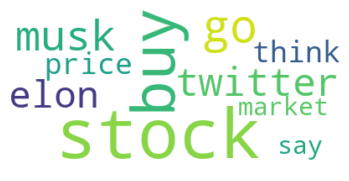

In [66]:
make_wordcloud(get_topic_words(0, 10))